In [1253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint

In [527]:
df = pd.read_csv('updated_diamonds.csv')

## EDA

In [528]:
df.drop('Unnamed: 0',axis =1, inplace=True) #removing column that was basically the same as the index
df.drop_duplicates(inplace = True) #might be some duplicate rows based on the way the data was scraped (changing floor price)

In [529]:
df.info() #data types are as expected

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52461 entries, 0 to 52885
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   shape             52461 non-null  object 
 1   original_price    52461 non-null  int64  
 2   discounted_price  6796 non-null   float64
 3   carat             52461 non-null  float64
 4   cut               52461 non-null  object 
 5   color             52461 non-null  object 
 6   clarity           52461 non-null  object 
 7   polish            52461 non-null  object 
 8   symmetry          52461 non-null  object 
 9   fluorescence      52461 non-null  object 
 10  depth             52461 non-null  float64
 11  table             52461 non-null  float64
 12  lxwratio          52461 non-null  float64
 13  culet             52461 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 6.0+ MB


In [531]:
#Astor Ideal and showing up as ealAstor - need to update
df['cut'] = df['cut'].replace('ealAstor','Astor Ideal')

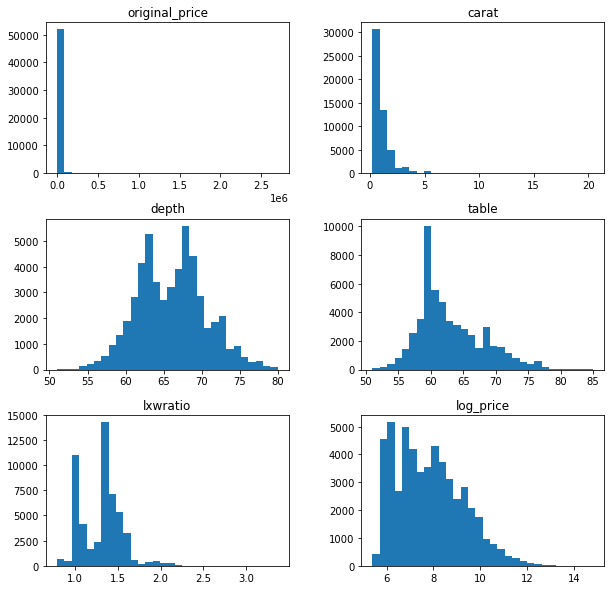

In [1335]:
df['log_price'] = np.log(df['original_price'])
df.hist(figsize=(10,10),bins=30,grid=False);

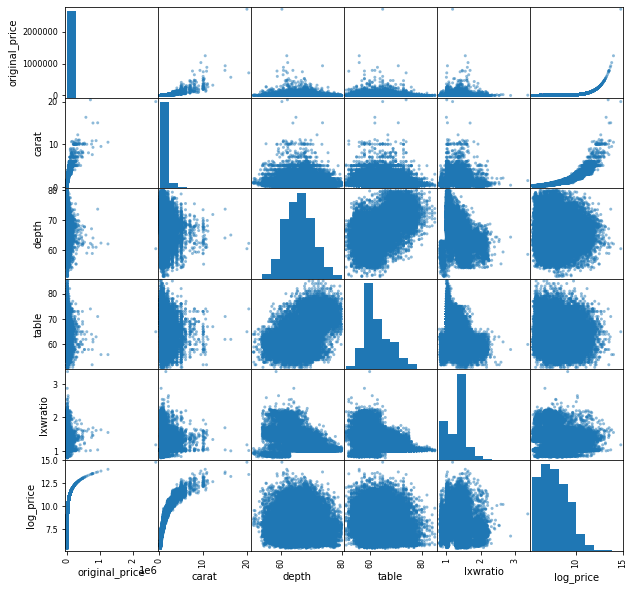

In [1700]:
pd.plotting.scatter_matrix(df,figsize=(10,10));

In [1171]:
df.describe()

,original_price,carat,depth,table,lxwratio,log_price
count,5.246100e+04,52461.000000,52461.000000,52461.000000,52461.000000,5.246100e+04
mean,7.941095e+03,0.993874,66.088462,62.946719,1.308527,7.941095e+03
std,2.688281e+04,0.909858,4.517800,5.039816,0.236147,2.688281e+04
min,2.210000e+02,0.230000,51.000000,51.000000,0.790000,2.210000e+02
25%,7.930000e+02,0.400000,62.700000,59.000000,1.050000,7.930000e+02
50%,2.152000e+03,0.710000,66.200000,62.000000,1.350000,2.152000e+03
75%,6.409000e+03,1.200000,68.900000,66.000000,1.440000,6.409000e+03
max,2.702260e+06,20.450000,80.000000,85.000000,3.370000,2.702260e+06


In [534]:
df.corr()

,original_price,discounted_price,carat,depth,table,lxwratio
original_price,1.000000,0.996543,0.750451,-0.001705,0.009492,-0.022267
discounted_price,0.996543,1.000000,0.821921,0.021983,0.024054,-0.041886
carat,0.750451,0.821921,1.000000,0.050836,0.015941,-0.111207
depth,-0.001705,0.021983,0.050836,1.000000,0.592803,-0.555673
table,0.009492,0.024054,0.015941,0.592803,1.000000,-0.446653
lxwratio,-0.022267,-0.041886,-0.111207,-0.555673,-0.446653,1.000000


need to remove discounted price since we are trying to predict original price or else there might be data leakage - model will have the information you are trying to predict

In [535]:
df.drop('discounted_price',axis =1,inplace = True)

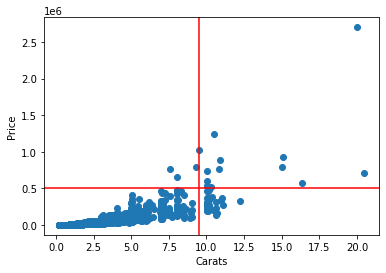

In [1729]:
#there are outliers - one diamond is almost 3 million!
fig,ax = plt.subplots()
ax.scatter(df.carat,(df.original_price))
ax.set_xlabel('Carats')
ax.set_ylabel('Price')
plt.axvline(x=9.5, color = 'r')
plt.axhline(500000, color = 'r');

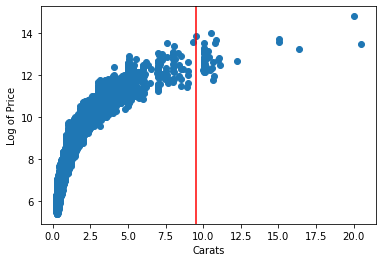

In [1310]:
fig,ax = plt.subplots()
ax.scatter(df.carat,np.log(df.original_price))
ax.set_xlabel('Carats')
ax.set_ylabel('Log of Price')
plt.axvline(x=9.5, color = 'r');

Any specific patterns that jump out with respect to price? Diamond Price vs. 2 Predictors

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


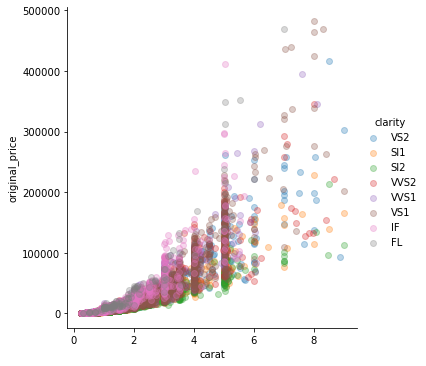

In [1703]:
sns.lmplot('carat','original_price', data=df_filtered,hue='clarity', fit_reg =False, scatter_kws = {'alpha': .3})

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


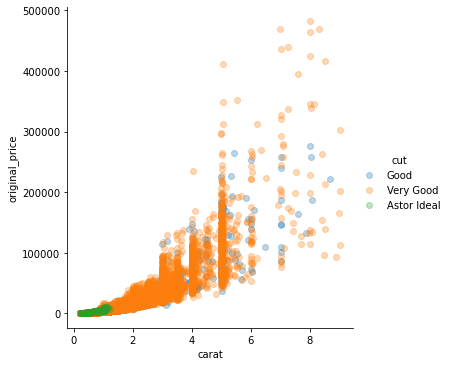

In [1702]:
sns.lmplot('carat','original_price', data=df_filtered,hue='cut', fit_reg =False, scatter_kws = {'alpha': 0.3})

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


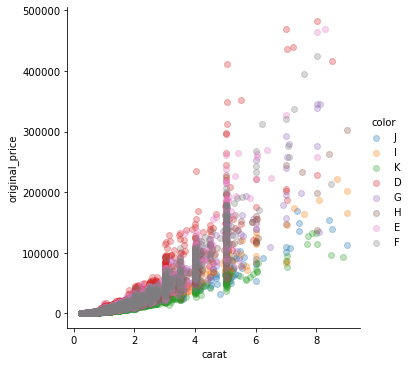

In [1701]:
sns.lmplot('carat','original_price', data=df_filtered,hue='color', fit_reg =False, scatter_kws = {'alpha': 0.3})

In [1327]:
print(f'Percent of data to drop: {df[(df.carat>9.5) & (df.original_price>600000)].shape[0]/df.shape[0]*100}%')

Percent of data to drop: 0.017155601303825697%


In [1337]:
df_filtered = df[(df.carat<9.5) & (df.original_price<500000)]
df_filtered

,shape,original_price,carat,cut,color,clarity,polish,symmetry,fluorescence,depth,table,lxwratio,culet,log_price
0,Emerald,221,0.30,Good,J,VS2,Very Good,Good,None,70.0,61.0,1.33,None,5.398163
1,Emerald,224,0.30,Very Good,J,SI1,Excellent,Very Good,Faint,65.9,66.0,1.42,None,5.411646
2,Emerald,224,0.30,Very Good,J,SI1,Excellent,Very Good,Faint,66.6,66.0,1.28,None,5.411646
3,Pear,225,0.30,Very Good,J,SI1,Very Good,Very Good,Faint,61.7,62.0,1.60,None,5.416100
4,Pear,226,0.30,Very Good,J,SI2,Very Good,Very Good,None,62.5,59.0,1.57,None,5.420535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52861,Emerald,439952,7.25,Very Good,D,VS1,Excellent,Very Good,None,64.4,65.0,1.43,None,12.994421
52863,Oval,464826,8.02,Very Good,E,VS1,Excellent,Very Good,None,62.2,57.0,1.38,None,13.049418
52865,Emerald,469643,8.30,Very Good,E,VS1,Excellent,Excellent,None,68.1,69.0,1.60,None,13.059728
52866,Emerald,469665,7.00,Very Good,D,FL,Excellent,Very Good,None,66.7,68.0,1.34,None,13.059775


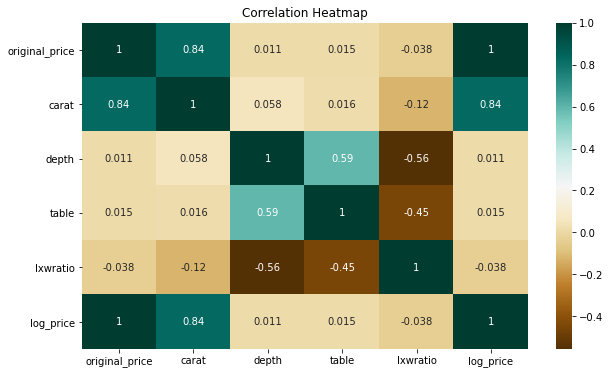

In [1207]:
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(df_filtered.corr(),cmap = 'BrBG',annot = True)
heatmap.set_title('Correlation Heatmap');

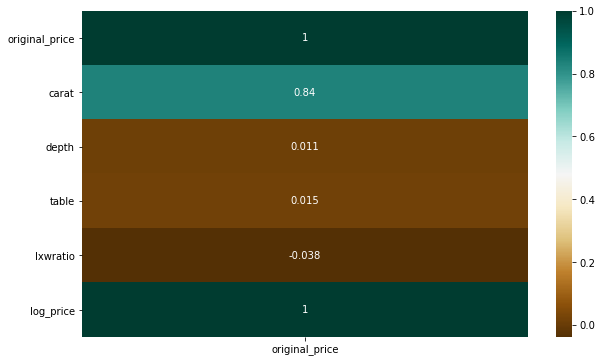

In [1209]:
plt.figure(figsize = (10,6))
sns.heatmap(df_filtered.corr()[['original_price']],cmap = 'BrBG',annot=True);

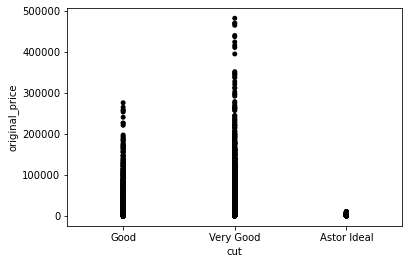

In [1213]:
sns.stripplot(data = df_filtered,
              x='cut', y='original_price', 
              order = ['Good','Very Good','Astor Ideal'],
              color = 'black', jitter=False);

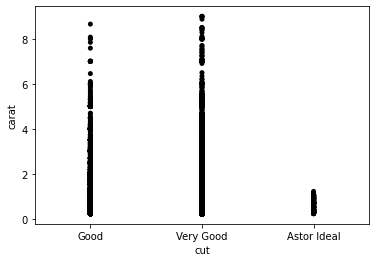

In [1214]:
sns.stripplot(data = df_filtered,
              x='cut', y='carat', 
              order = ['Good','Very Good','Astor Ideal'],
              color = 'black', jitter=False);

In [1215]:
len(df_filtered[df_filtered.cut == 'Astor Ideal']['cut'])/df.shape[0] #less than one percent of diamonds are astor ideal

0.009759630963954175

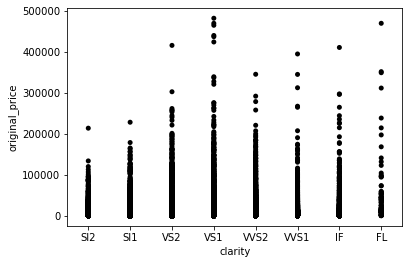

In [1216]:
sns.stripplot(data = df_filtered,
              x='clarity', y='original_price', 
              order = ['SI2','SI1','VS2','VS1','VVS2','VVS1','IF','FL'],
              color = 'black', jitter=False);

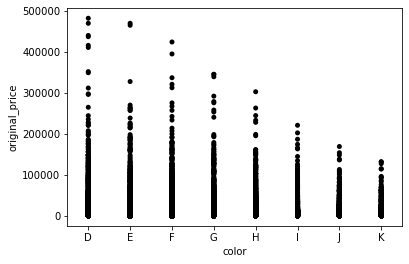

In [1225]:
sns.stripplot(data = df_filtered,
              x='color', y='original_price', 
              order = ['D', 'E','F','G','H','I','J','K'],
              color = 'black', jitter=False);

## Linear Regression Model

## Predicting log of price

In [1608]:
linreg = LinearRegression()

X = df.drop(['original_price','log_price'],axis = 1)
y = df.log_price
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [1609]:
X_train_1 = pd.get_dummies(X_train)
X_test_1 = pd.get_dummies(X_test)
y_predicted_1 = linreg.fit(X_train_1,y_train).predict(X_test_1)



print(f'Train RMSE: {(-cross_val_score(linreg,X_train_1,y_train,scoring="neg_root_mean_squared_error")).mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_predicted_1))}')
print(f'Train R2: {cross_val_score(linreg,X_train_1,y_train,scoring="r2").mean()}')
print(f'Test R2: {r2_score(y_test,y_predicted_1)}')
print(f'Mean Absolute Percentage Error: {np.exp(mean_absolute_percentage_error(y_test,y_predicted_1))}')

Train RMSE: 0.6435554942097502
Test RMSE: 0.6112483374316493
Train R2: 0.7924915025250793
Test R2: 0.8108517324162573
Mean Absolute Percentage Error: 1.0653315259015774


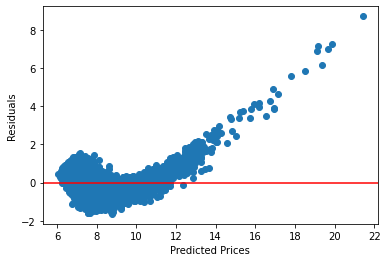

In [1610]:
predicted = linreg.fit(X_train_1,y_train).predict(X_test_1)
residuals = predicted - y_test

fig,ax = plt.subplots()
ax.scatter(predicted ,residuals)
plt.axhline(y=0, color = 'r')
ax.set_xlabel('Predicted Prices')
ax.set_ylabel('Residuals');

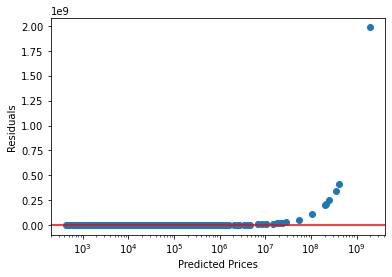

In [1611]:
predicted = linreg.fit(X_train_1,y_train).predict(X_test_1)
residuals = np.exp(predicted) - np.exp(y_test)

fig,ax = plt.subplots()
ax.scatter(np.exp(predicted),residuals)
plt.axhline(y=0, color = 'r')
plt.xscale('log')
ax.set_xlabel('Predicted Prices')
ax.set_ylabel('Residuals');

## Predicting log of price with outliers removed

In [1614]:
linreg = LinearRegression()

X = df_filtered.drop(['original_price','log_price'],axis = 1)
y = df_filtered.log_price
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [1615]:
X_train_1 = pd.get_dummies(X_train)
X_test_1 = pd.get_dummies(X_test)
y_predicted_1 = linreg.fit(X_train_1,y_train).predict(X_test_1)



print(f'Train RMSE: {(-cross_val_score(linreg,X_train_1,y_train,scoring="neg_root_mean_squared_error")).mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_predicted_1))}')
print(f'Train R2: {cross_val_score(linreg,X_train_1,y_train,scoring="r2").mean()}')
print(f'Test R2: {r2_score(y_test,y_predicted_1)}')
print(f'Mean Absolute Percentage Error: {np.exp(mean_absolute_percentage_error(y_test,y_predicted_1))}')

Train RMSE: 0.5721003229159649
Test RMSE: 0.5826494179147667
Train R2: 0.8338867300716057
Test R2: 0.8268713294808613
Mean Absolute Percentage Error: 1.0610272395312743


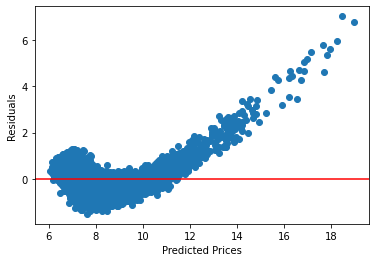

In [1616]:
predicted = linreg.fit(X_train_1,y_train).predict(X_test_1)
residuals = predicted - y_test

fig,ax = plt.subplots()
ax.scatter(predicted,residuals)
plt.axhline(y=0, color = 'r')
ax.set_xlabel('Predicted Prices')
ax.set_ylabel('Residuals');

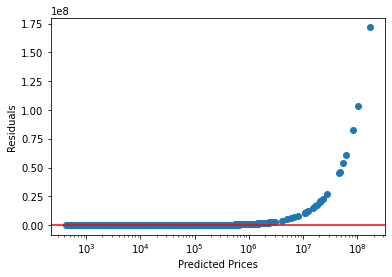

In [1617]:
predicted = linreg.fit(X_train_1,y_train).predict(X_test_1)
residuals = np.exp(predicted) - np.exp(y_test)

fig,ax = plt.subplots()
ax.scatter(np.exp(predicted),residuals)
plt.axhline(y=0, color = 'r')
plt.xscale('log')
ax.set_xlabel('Predicted Prices')
ax.set_ylabel('Residuals');

### Predicting price - removing outliers

In [1622]:
linreg = LinearRegression()

X = df_filtered.drop(['original_price','log_price'],axis = 1)
y = df_filtered.original_price
X_train, X_test, y_train, y_test = train_test_split(X,y)

Try using all features

In [1623]:
X_train_1 = pd.get_dummies(X_train)
X_test_1 = pd.get_dummies(X_test)
y_predicted_1 = linreg.fit(X_train_1,y_train).predict(X_test_1)
print(f'Train RMSE: {-cross_val_score(linreg,X_train_1,y_train,scoring="neg_root_mean_squared_error").mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,y_predicted_1))}')
print(f'Train R2: {cross_val_score(linreg,X_train_1,y_train,scoring="r2").mean()}')
print(f'Test R2: {linreg.score(X_test_1,y_test)}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test,y_predicted_1)}')

Train RMSE: 9141.504272753478
Test RMSE: 9687.180098618204
Train R2: 0.7557852982291756
Test R2: 0.7395497667262476
Mean Absolute Percentage Error: 3.2526152124172265


In [1624]:
scaler = StandardScaler()
scaler.fit(X_train_1)
X_train_s = scaler.transform(X_train_1)
linreg.fit(X_train_1,y_train)

np.abs(linreg.coef_)

array([20164.99868147,   188.13751115,   130.32001857,  1622.00884091,
         975.58982838,  2288.79477806,  2077.94302354,   465.86586755,
         234.74533558,   605.12395617,   296.1492559 ,  3659.56710377,
        1933.03028863,  3351.07856917,  2172.88959906,  1178.18897011,
        4129.92169613,  3850.87208812,  3138.43963266,  1419.5150836 ,
         257.85386317,  1862.51496402,  3818.09177802,  7115.99562164,
       15219.97816321,   266.20356873,  3380.87409967,  5986.45552542,
        1317.36632754,  2687.52907511,   788.84169503,  1325.11500917,
         343.50901297,   239.60726865,   583.11628162,  1733.24180208,
        1118.76418334,   614.47761874,  2174.51666598,  1095.9549488 ,
         970.41037703,   853.51219386,  1442.29878722,  2629.6554681 ,
         805.34441153,   571.89654795,  1537.59563214,  4544.48746166,
         161.63450849,  1679.99135213,   197.50875064,  3700.5843161 ,
        1001.091381  ,  1602.12925877,  1383.68084405])

Look at coefficients to see if there is some insight from feature importance

In [1625]:
coefficients = pd.concat([pd.DataFrame(X_train_1.columns, columns = ['features']),pd.DataFrame(np.transpose(np.abs(linreg.coef_)),columns = ['coefs'])], axis = 1)
coefficients.sort_values(by=['coefs'],ascending=False)

,features,coefs
0,carat,20164.998681
24,clarity_FL,15219.978163
23,color_K,7115.995622
27,clarity_SI2,5986.455525
47,fluorescence_Very Strong Blue,4544.487462
16,color_D,4129.921696
17,color_E,3850.872088
22,color_J,3818.091778
51,culet_Pointed,3700.584316
11,shape_Princess,3659.567104


In [1709]:
X_train_2 = X_train[['carat','cut','clarity', 'color']]
X_train_2 = pd.get_dummies(X_train_2)
X_test_2 = X_test[['carat','cut','clarity', 'color']]
X_test_2 = pd.get_dummies(X_test_2)
y_predicted_2 = linreg.fit(X_train_2,y_train).predict(X_test_2)
print(f'Train RMSE: {-cross_val_score(linreg,X_train_2,y_train,scoring="neg_root_mean_squared_error").mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,y_predicted_2))}')
print(f'Train R2: {cross_val_score(linreg,X_train_2,y_train,scoring="r2").mean()}')
print(f'Train R2: {r2_score(y_test,y_predicted_2)}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test,y_predicted_2)}')

Train RMSE: 9450.817921586397
Test RMSE: 9998.047607442815
Train R2: 0.7389904358415267
Train R2: 0.7225655400063519
Mean Absolute Percentage Error: 3.6648014944479845


In [1627]:
X_train_3 = X_train[['carat']]
X_train_3 = pd.get_dummies(X_train_3)
X_test_3 = X_test[['carat']]
X_test_3 = pd.get_dummies(X_test_3)
y_predicted_3 = linreg.fit(X_train_3,y_train).predict(X_test_3)
print(f'Train RMSE: {-cross_val_score(linreg,X_train_3,y_train,scoring="neg_root_mean_squared_error").mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,y_predicted_3))}')
print(f'Train R2: {cross_val_score(linreg,X_train_3,y_train,scoring="r2").mean()}')
print(f'Train R2: {r2_score(y_test,y_predicted_3)}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test,y_predicted_3)}')

Train RMSE: 10089.970066999978
Test RMSE: 10624.364771299917
Train R2: 0.7024250715882936
Train R2: 0.6867176347338866
Mean Absolute Percentage Error: 3.7283720907600597


The plot below exhibits “heteroscedasticity,” meaning that the residuals get larger as the prediction moves from small to large (or from large to small).

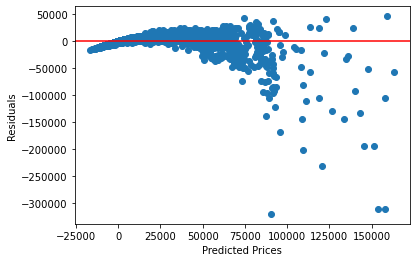

In [1628]:
predicted = linreg.fit(X_train_1,y_train).predict(X_test_1)
residuals = predicted - y_test

fig,ax = plt.subplots()
ax.scatter(predicted,residuals)
plt.axhline(y=0, color = 'r')
ax.set_xlabel('Predicted Prices')
ax.set_ylabel('Residuals');

## Random Forest

In [1720]:
#using all features
rf= RandomForestRegressor(n_jobs=-1).fit(X_train_1,y_train)
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,rf.predict(X_test_1)))}')
print(f'Train R2: {cross_val_score(rf,X_train_1,y_train,scoring="r2").mean()}')
print(f'Test R2: {r2_score(y_test,rf.predict(X_test_1))}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test,y_predicted_1)}')

Train RMSE: 4632.766425417786
Test RMSE: 4474.799683525393
Train R2: 0.9361039538291621
Test R2: 0.9444252906332218
Mean Absolute Percentage Error: 3.2526152124172265


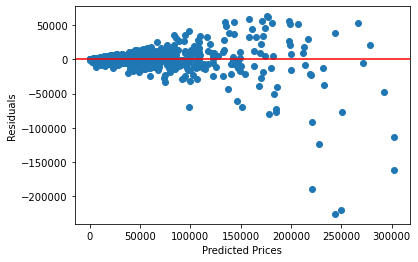

In [1607]:
predicted = rf.fit(X_train_1,y_train).predict(X_test_1)
residuals = predicted - y_test

fig,ax = plt.subplots()
ax.scatter(predicted,residuals)
plt.axhline(y=0, color = 'r')
ax.set_xlabel('Predicted Prices')
ax.set_ylabel('Residuals');

Text(0, 0.5, 'percent error')

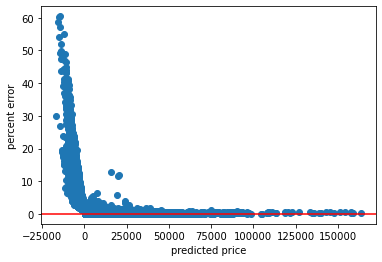

In [1661]:
percent_error = np.abs(y_test - y_predicted_1)/y_test
fig,ax = plt.subplots()
ax.scatter(y_predicted_1,percent_error)
ax.set_xlabel('predicted price')
plt.axhline(y=0, color = 'r')
ax.set_ylabel('percent error')

Looking to see if there are any patterns for ones we over-estimate/under-estimate

In [1677]:
actual_predicted = pd.DataFrame(y_test)
actual_predicted['predicted'] = y_predicted_1
actual_predicted['diff'] = actual_predicted.predicted - actual_predicted.original_price
merge = X_test
merged = merge.merge(actual_predicted, left_index=True, right_index=True, how='inner')
#under predicted
under = merged[merged['diff']<0]

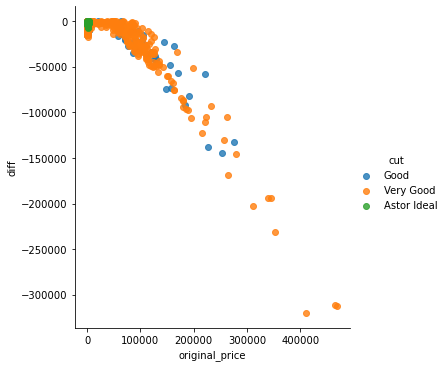

In [1742]:
sns.lmplot('original_price','diff', data=under,hue='cut', fit_reg =False)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


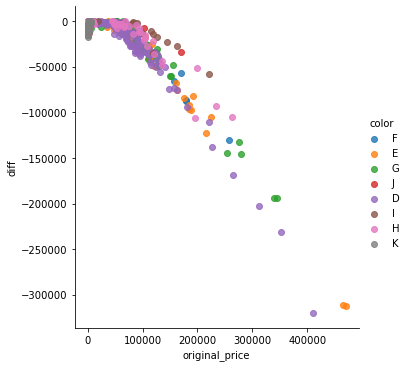

In [1743]:
sns.lmplot('original_price','diff', data=under,hue='color', fit_reg =False)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


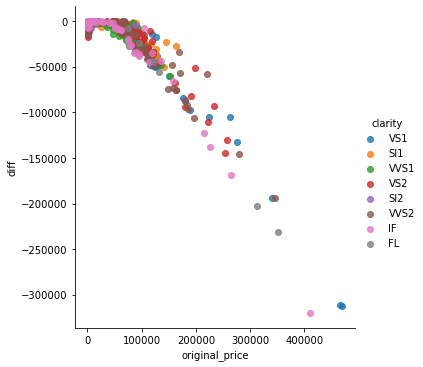

In [1744]:
sns.lmplot('original_price','diff', data=under,hue='clarity', fit_reg =False)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


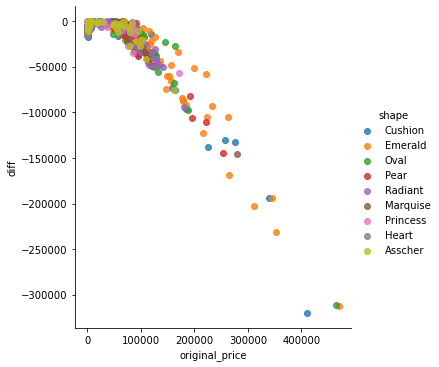

In [1745]:
sns.lmplot('original_price','diff', data=under,hue='shape', fit_reg =False)

In [1663]:
#over predicting
merged[merged['diff']>0]

,carat,depth,table,lxwratio,shape_Asscher,shape_Cushion,shape_Emerald,shape_Heart,shape_Marquise,shape_Oval,...,culet_Large,culet_Medium,culet_None,culet_Pointed,culet_Slightly Large,culet_Small,culet_Very Small,original_price,predicted,diff
47451,2.22,68.5,62.0,1.10,0,1,0,0,0,0,...,0,0,1,0,0,0,0,16636,25058.687234,8422.687234
32192,0.90,63.0,62.0,1.34,0,0,0,0,0,1,...,0,0,1,0,0,0,0,3327,5097.947289,1770.947289
46500,2.01,69.0,77.0,1.02,0,0,0,0,0,0,...,0,0,1,0,0,0,0,14398,27320.839248,12922.839248
30481,0.90,70.1,60.0,1.21,0,1,0,0,0,0,...,0,0,1,0,0,0,0,2942,5916.672126,2974.672126
40195,1.51,65.1,62.0,1.33,0,0,0,0,0,1,...,0,0,1,0,0,0,0,6680,10270.144902,3590.144902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48842,2.01,74.3,76.0,1.03,0,0,0,0,0,0,...,0,0,1,0,0,0,0,21240,29966.471491,8726.471491
39397,1.03,62.3,57.0,1.50,0,0,0,0,0,0,...,0,0,1,0,0,0,0,6117,12215.552082,6098.552082
30621,0.70,67.9,62.0,1.58,0,0,1,0,0,0,...,0,0,1,0,0,0,0,2970,5593.900714,2623.900714
35224,1.01,63.0,57.0,1.91,0,0,0,0,1,0,...,0,0,1,0,0,0,0,4201,4738.842303,537.842303


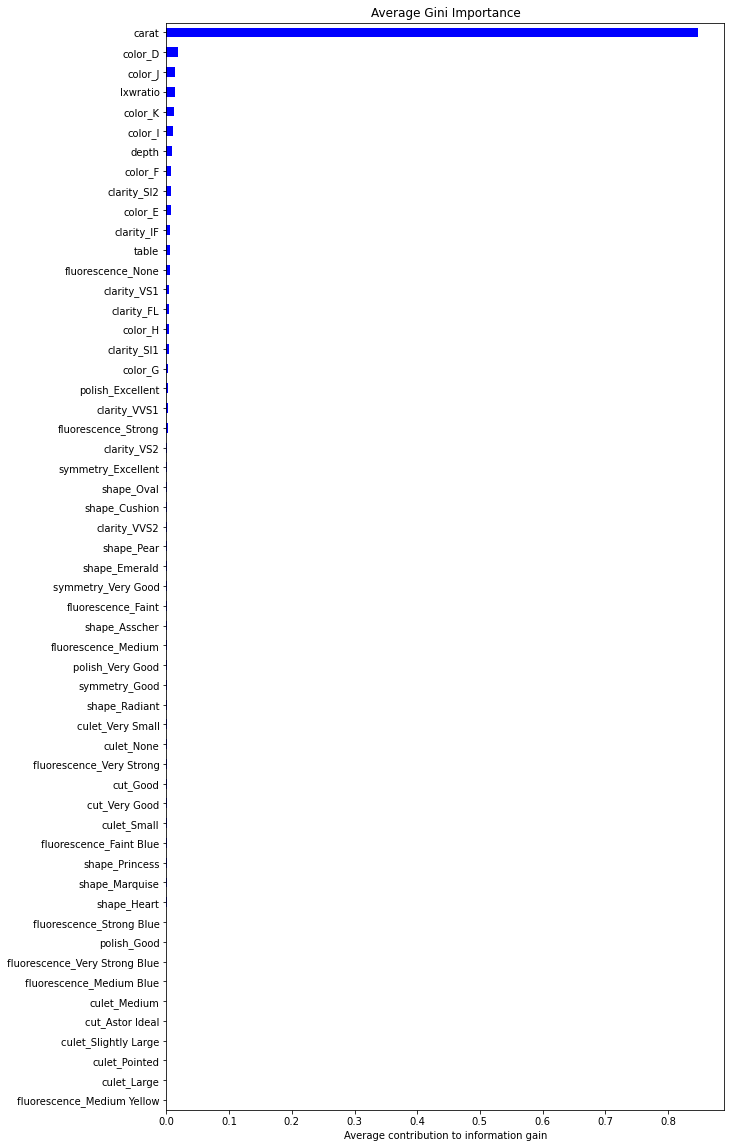

In [1723]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=X_train_1.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,20),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

Looks like it is underfitting but regardless it looks like my model's performance isn't changing much

In [1710]:
#remove features/only using 4c's - improved but still overfitting to training data
rf= RandomForestRegressor(n_jobs=-1).fit(X_train_2,y_train)
print(f'Train RMSE: {-cross_val_score(rf,X_train_2,y_train, scoring="neg_root_mean_squared_error").mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,rf.predict(X_test_2)))}')

Train RMSE: 4664.228872961501
Test RMSE: 4298.63295021853


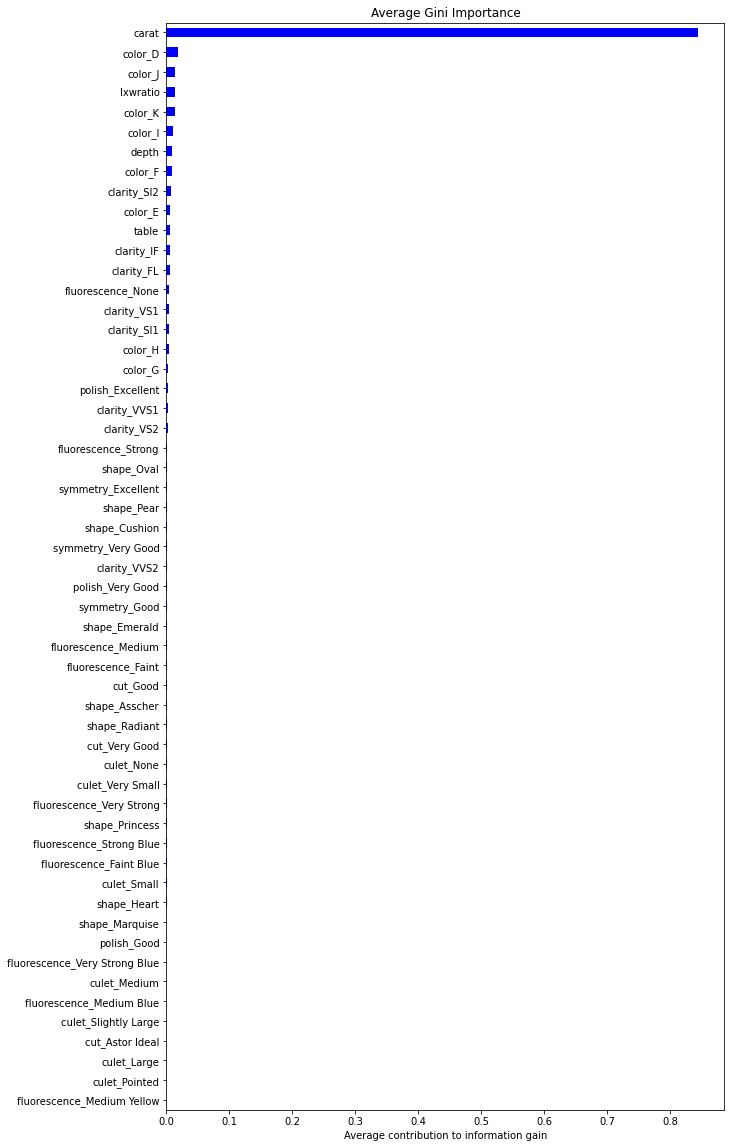

In [1666]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=X_train_.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,20),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

In [1063]:
#creating a random grid
n_estimators = [int(x) for x in np.linspace(start=200,stop=500, num =4)]
max_features = ['auto','sqrt']
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]

random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}